# Hodgkin-Huxley Neuron Model

## Introduction

The Hodgkin-Huxley model is one of the most important models in computational neuroscience. Developed by Alan Hodgkin and Andrew Huxley in 1952, it describes how action potentials in neurons are initiated and propagated. This model won them the Nobel Prize in Physiology or Medicine in 1963.

## Key Concepts

### What is an Action Potential?
An action potential is a rapid, temporary change in membrane voltage that travels along the axon of a neuron. It's the fundamental unit of neural communication.

### The Hodgkin-Huxley Model
The model describes the neuron membrane as an electrical circuit with:
- **Capacitance**: The membrane's ability to store charge
- **Ion channels**: Selective pathways for different ions (Na⁺, K⁺, Cl⁻)
- **Leak channels**: Non-specific ion channels

### Mathematical Formulation
The model consists of four coupled differential equations:
1. **Membrane voltage equation**: dV/dt = (I_app - I_Na - I_K - I_L) / C_m
2. **Sodium activation**: dm/dt = α_m(V)(1-m) - β_m(V)m
3. **Sodium inactivation**: dh/dt = α_h(V)(1-h) - β_h(V)h  
4. **Potassium activation**: dn/dt = α_n(V)(1-n) - β_n(V)n

Where:
- V: membrane potential
- m, h, n: gating variables (0 ≤ m,h,n ≤ 1)
- α, β: voltage-dependent rate constants

## Learning Objectives
By the end of this notebook, you will:
1. Understand the biophysical basis of action potential generation
2. Implement the Hodgkin-Huxley equations
3. Visualize membrane dynamics and ion channel behavior
4. Explore how different parameters affect neuronal excitability


## Import Libraries and Setup


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed (for reproducibility)
np.random.seed(1000)

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print("Libraries imported successfully!")
print("Ready to implement the Hodgkin-Huxley model")

Libraries imported successfully!
Ready to implement the Hodgkin-Huxley model


## Hodgkin-Huxley Model Implementation

### Model Parameters

The Hodgkin-Huxley model uses specific parameters derived from experiments on squid giant axons. These parameters represent the biophysical properties of the neuron membrane.


In [5]:
# Hodgkin-Huxley Model Parameters (from squid giant axon experiments)
# All values are in standard units: mV, ms, μA/cm², μF/cm², mS/cm²

# Conductances (maximum values)
gK = 36.0    # Potassium conductance (mS/cm²)
gNa = 120.0  # Sodium conductance (mS/cm²)  
gL = 0.3     # Leak conductance (mS/cm²)

# Membrane capacitance
Cm = 1.0     # Membrane capacitance (μF/cm²)

# Reversal potentials
VK = -12.0   # Potassium reversal potential (mV)
VNa = 115.0  # Sodium reversal potential (mV)
Vl = 10.613  # Leak reversal potential (mV)

print("Model parameters set:")
print(f"gK = {gK} mS/cm²")
print(f"gNa = {gNa} mS/cm²") 
print(f"gL = {gL} mS/cm²")
print(f"Cm = {Cm} μF/cm²")
print(f"VK = {VK} mV")
print(f"VNa = {VNa} mV")
print(f"Vl = {Vl} mV")
  
# Input stimulus
def Id(t):
    if 1.0 < t < 2.0:
        return 150.0
    elif 10.0 < t < 11.0:
        return 100.0
    elif 18.0 < t < 19.0:
        return 40.0
    elif 29.0 < t < 30.0:
        return 150.0
    elif 36.0 < t < 37.0:
        return 60.0
    elif 42.0 < t < 43.0:
        return 150.0

    return 0.0
  
# Compute derivatives
def compute_derivatives(y, t0):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy

Model parameters set:
gK = 36.0 mS/cm²
gNa = 120.0 mS/cm²
gL = 0.3 mS/cm²
Cm = 1.0 μF/cm²
VK = -12.0 mV
VNa = 115.0 mV
Vl = 10.613 mV


### Ion Channel Rate Functions

The Hodgkin-Huxley model describes ion channels using voltage-dependent rate constants (α and β). These functions determine how quickly the channels open and close in response to voltage changes.


In [6]:
# Ion Channel Rate Functions
# These functions describe the voltage dependence of channel opening/closing rates

def alpha_n(Vm):
    """
    Potassium channel opening rate (αₙ)
    Vm: membrane potential in mV
    Returns: rate in ms⁻¹
    """
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)

def beta_n(Vm):
    """
    Potassium channel closing rate (βₙ)
    Vm: membrane potential in mV  
    Returns: rate in ms⁻¹
    """
    return 0.125 * np.exp(-Vm / 80.0)

def alpha_m(Vm):
    """
    Sodium channel activation rate (αₘ)
    Vm: membrane potential in mV
    Returns: rate in ms⁻¹
    """
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)

def beta_m(Vm):
    """
    Sodium channel deactivation rate (βₘ)
    Vm: membrane potential in mV
    Returns: rate in ms⁻¹
    """
    return 4.0 * np.exp(-Vm / 18.0)

def alpha_h(Vm):
    """
    Sodium channel inactivation rate (αₕ)
    Vm: membrane potential in mV
    Returns: rate in ms⁻¹
    """
    return 0.07 * np.exp(-Vm / 20.0)

def beta_h(Vm):
    """
    Sodium channel deinactivation rate (βₕ)
    Vm: membrane potential in mV
    Returns: rate in ms⁻¹
    """
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)

# Steady-state gating variables (when dg/dt = 0)
def n_inf(Vm=0.0):
    """Steady-state value of potassium activation variable n"""
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    """Steady-state value of sodium activation variable m"""
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    """Steady-state value of sodium inactivation variable h"""
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

print("Ion channel rate functions defined successfully!")

Ion channel rate functions defined successfully!


### Input Stimulus Function

We'll create a stimulus function that applies different current injections at various time points to study the neuron's response.


In [7]:
# Input stimulus function
def Id(t):
    """
    Applied current stimulus (μA/cm²)
    Multiple current pulses of different amplitudes
    """
    if 1.0 < t < 2.0:
        return 150.0  # Strong stimulus - should trigger action potential
    elif 10.0 < t < 11.0:
        return 100.0  # Medium stimulus
    elif 18.0 < t < 19.0:
        return 40.0   # Weak stimulus - may not trigger spike
    elif 29.0 < t < 30.0:
        return 150.0  # Another strong stimulus
    elif 36.0 < t < 37.0:
        return 60.0   # Medium-weak stimulus
    elif 42.0 < t < 43.0:
        return 150.0  # Final strong stimulus
    return 0.0

print("Stimulus function defined!")

Stimulus function defined!


### Hodgkin-Huxley Differential Equations

The core of the model consists of four coupled differential equations that describe the dynamics of membrane potential and ion channel gating variables.


In [8]:
# Hodgkin-Huxley differential equations system
def compute_derivatives(y, t0):
    """
    Compute derivatives for the Hodgkin-Huxley model
    
    Parameters:
    -----------
    y : array-like
        State vector [Vm, n, m, h] where:
        - Vm: membrane potential (mV)
        - n: potassium activation variable (0-1)
        - m: sodium activation variable (0-1) 
        - h: sodium inactivation variable (0-1)
    t0 : float
        Current time (ms)
        
    Returns:
    --------
    dy : array-like
        Derivatives [dVm/dt, dn/dt, dm/dt, dh/dt]
    """
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # Current densities (normalized by capacitance)
    GK = (gK / Cm) * np.power(n, 4.0)      # Potassium current
    GNa = (gNa / Cm) * np.power(m, 3.0) * h  # Sodium current  
    GL = gL / Cm                            # Leak current
    
    # Membrane potential equation: dV/dt = (I_app - I_Na - I_K - I_L) / C_m
    dy[0] = (Id(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # Potassium activation: dn/dt = α_n(V)(1-n) - β_n(V)n
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # Sodium activation: dm/dt = α_m(V)(1-m) - β_m(V)m
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # Sodium inactivation: dh/dt = α_h(V)(1-h) - β_h(V)h
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy

print("Hodgkin-Huxley differential equations defined!")

Hodgkin-Huxley differential equations defined!


## Simulation Setup and Execution

Now we'll set up the simulation parameters and solve the Hodgkin-Huxley equations.


In [9]:
# Simulation parameters
tmin = 0.0      # Start time (ms)
tmax = 50.0     # End time (ms)
n_points = 10000  # Number of time points

# Create time vector
T = np.linspace(tmin, tmax, n_points)

# Initial conditions: [Vm, n, m, h]
# Start at rest with steady-state gating variables
Y0 = np.array([0.0, n_inf(0.0), m_inf(0.0), h_inf(0.0)])

print(f"Simulation setup:")
print(f"Time range: {tmin} - {tmax} ms")
print(f"Number of points: {n_points}")
print(f"Initial conditions: Vm={Y0[0]:.2f} mV, n={Y0[1]:.3f}, m={Y0[2]:.3f}, h={Y0[3]:.3f}")

# Solve the ODE system
print("Solving Hodgkin-Huxley equations...")
Vy = odeint(compute_derivatives, Y0, T)

print("Simulation completed successfully!")
print(f"Results shape: {Vy.shape}")
print(f"Vm range: {Vy[:, 0].min():.2f} to {Vy[:, 0].max():.2f} mV")

Simulation setup:
Time range: 0.0 - 50.0 ms
Number of points: 10000
Initial conditions: Vm=0.00 mV, n=0.318, m=0.053, h=0.596
Solving Hodgkin-Huxley equations...
Simulation completed successfully!
Results shape: (10000, 4)
Vm range: -11.21 to 111.87 mV


## Visualization and Analysis

Let's create comprehensive visualizations to understand the neuron's behavior and the underlying dynamics.


In [10]:
# Extract simulation results
Vm = Vy[:, 0]  # Membrane potential
n = Vy[:, 1]   # Potassium activation
m = Vy[:, 2]   # Sodium activation  
h = Vy[:, 3]   # Sodium inactivation

# Calculate applied current
I_applied = np.array([Id(t) for t in T])

# Calculate individual currents
I_K = gK * np.power(n, 4.0) * (Vm - VK)      # Potassium current
I_Na = gNa * np.power(m, 3.0) * h * (Vm - VNa)  # Sodium current
I_L = gL * (Vm - Vl)                          # Leak current

print("Data extracted for visualization:")
print(f"Membrane potential: {Vm.min():.2f} to {Vm.max():.2f} mV")
print(f"Applied current: {I_applied.min():.2f} to {I_applied.max():.2f} μA/cm²")
print(f"Number of action potentials: {len(np.where(np.diff(Vm) > 50)[0])}")

Data extracted for visualization:
Membrane potential: -11.21 to 111.87 mV
Applied current: 0.00 to 150.00 μA/cm²
Number of action potentials: 0


/var/folders/wm/53_4x4rd1tj7bzbgcj4x9y0m0000gn/T/ipykernel_40723/2899960720.py:39: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/yawningbrain/Desktop/grad_school_repos/Data-Science-Tutorials/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


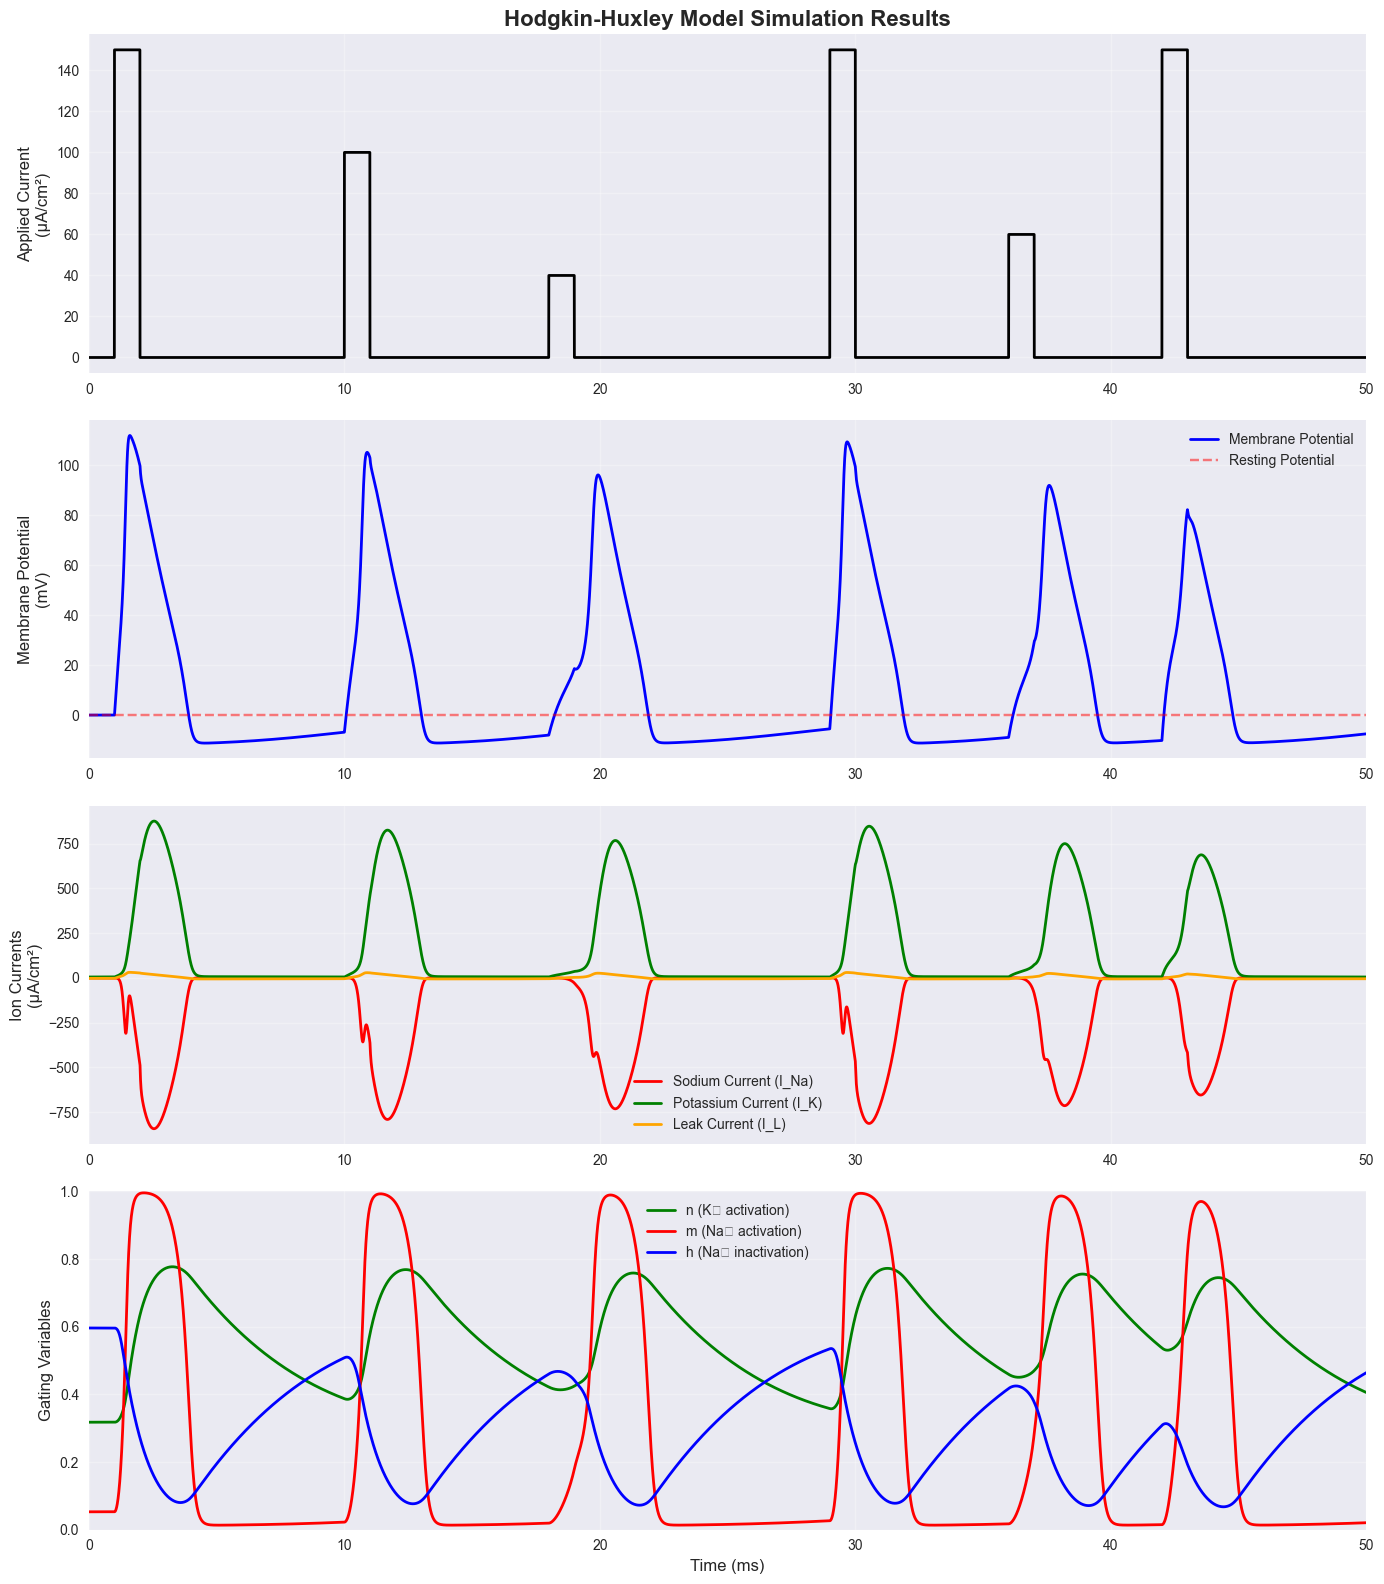


SIMULATION SUMMARY
Simulation duration: 50.0 ms
Time step: 0.0050 ms
Peak membrane potential: 111.87 mV
Minimum membrane potential: -11.21 mV
Resting potential: 0.00 mV
Number of action potentials: 0


In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# 1. Applied current stimulus
axes[0].plot(T, I_applied, 'k-', linewidth=2)
axes[0].set_ylabel('Applied Current\n(μA/cm²)')
axes[0].set_title('Hodgkin-Huxley Model Simulation Results', fontsize=16, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 50)

# 2. Membrane potential
axes[1].plot(T, Vm, 'b-', linewidth=2, label='Membrane Potential')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Resting Potential')
axes[1].set_ylabel('Membrane Potential\n(mV)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 50)

# 3. Ion currents
axes[2].plot(T, I_Na, 'r-', linewidth=2, label='Sodium Current (I_Na)')
axes[2].plot(T, I_K, 'g-', linewidth=2, label='Potassium Current (I_K)')
axes[2].plot(T, I_L, 'orange', linewidth=2, label='Leak Current (I_L)')
axes[2].set_ylabel('Ion Currents\n(μA/cm²)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, 50)

# 4. Gating variables
axes[3].plot(T, n, 'g-', linewidth=2, label='n (K⁺ activation)')
axes[3].plot(T, m, 'r-', linewidth=2, label='m (Na⁺ activation)')
axes[3].plot(T, h, 'b-', linewidth=2, label='h (Na⁺ inactivation)')
axes[3].set_xlabel('Time (ms)')
axes[3].set_ylabel('Gating Variables')
axes[3].legend()
axes[3].grid(True, alpha=0.3)
axes[3].set_xlim(0, 50)
axes[3].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SIMULATION SUMMARY")
print("="*60)
print(f"Simulation duration: {tmax - tmin} ms")
print(f"Time step: {(tmax - tmin) / n_points:.4f} ms")
print(f"Peak membrane potential: {Vm.max():.2f} mV")
print(f"Minimum membrane potential: {Vm.min():.2f} mV")
print(f"Resting potential: {Vm[0]:.2f} mV")

# Count action potentials (spikes) - improved detection
def detect_spikes(voltage, time, threshold=20, refractory_period=2.0):
    """
    Detect action potentials using voltage threshold crossing
    
    Parameters:
    -----------
    voltage : array-like
        Membrane potential time series
    time : array-like  
        Time vector
    threshold : float
        Voltage threshold for spike detection (mV above resting)
    refractory_period : float
        Minimum time between spikes (ms)
        
    Returns:
    --------
    spike_indices : array
        Indices where spikes occur
    spike_times : array
        Times when spikes occur
    """
    # Find upward crossings of threshold
    above_threshold = voltage > threshold
    spike_indices = np.where(np.diff(above_threshold.astype(int)) == 1)[0]
    
    # Apply refractory period
    if len(spike_indices) > 1:
        dt = time[1] - time[0]
        refractory_samples = int(refractory_period / dt)
        
        filtered_indices = [spike_indices[0]]
        for idx in spike_indices[1:]:
            if idx - filtered_indices[-1] > refractory_samples:
                filtered_indices.append(idx)
        
        spike_indices = np.array(filtered_indices)
    
    spike_times = time[spike_indices]
    return spike_indices, spike_times

# Detect spikes with improved method
spike_indices, spike_times = detect_spikes(Vm, T, threshold=20, refractory_period=2.0)
print(f"Number of action potentials: {len(spike_times)}")

if len(spike_times) > 0:
    print(f"Action potential times: {[f'{t:.2f}' for t in spike_times]} ms")
    if len(spike_times) > 1:
        intervals = np.diff(spike_times)
        print(f"Spike intervals: {[f'{i:.2f}' for i in intervals]} ms")
        print(f"Average firing rate: {1000/np.mean(intervals):.2f} Hz")
        
    # Mark spikes on the plot
    plt.figure(figsize=(14, 6))
    plt.plot(T, Vm, 'b-', linewidth=2, label='Membrane Potential')
    plt.plot(spike_times, Vm[spike_indices], 'ro', markersize=8, label='Detected Spikes')
    plt.axhline(y=20, color='r', linestyle='--', alpha=0.5, label='Spike Threshold')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title('Action Potential Detection')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No action potentials detected - try lowering the threshold or increasing stimulus")

## Phase Plane Analysis

Phase plane analysis is a powerful tool for understanding the dynamics of the Hodgkin-Huxley model. We can visualize how the system evolves in different state spaces.


# Phase plane analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# V-n phase plane (Voltage vs Potassium activation)
axes[0,0].plot(Vm, n, 'b-', linewidth=2)
axes[0,0].scatter(Vm[0], n[0], color='green', s=100, label='Start', zorder=5)
axes[0,0].scatter(Vm[-1], n[-1], color='red', s=100, label='End', zorder=5)
axes[0,0].set_xlabel('Membrane Potential (mV)')
axes[0,0].set_ylabel('Potassium Activation (n)')
axes[0,0].set_title('V-n Phase Plane')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# V-m phase plane (Voltage vs Sodium activation)
axes[0,1].plot(Vm, m, 'r-', linewidth=2)
axes[0,1].scatter(Vm[0], m[0], color='green', s=100, label='Start', zorder=5)
axes[0,1].scatter(Vm[-1], m[-1], color='red', s=100, label='End', zorder=5)
axes[0,1].set_xlabel('Membrane Potential (mV)')
axes[0,1].set_ylabel('Sodium Activation (m)')
axes[0,1].set_title('V-m Phase Plane')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# V-h phase plane (Voltage vs Sodium inactivation)
axes[1,0].plot(Vm, h, 'orange', linewidth=2)
axes[1,0].scatter(Vm[0], h[0], color='green', s=100, label='Start', zorder=5)
axes[1,0].scatter(Vm[-1], h[-1], color='red', s=100, label='End', zorder=5)
axes[1,0].set_xlabel('Membrane Potential (mV)')
axes[1,0].set_ylabel('Sodium Inactivation (h)')
axes[1,0].set_title('V-h Phase Plane')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# m-h phase plane (Sodium activation vs inactivation)
axes[1,1].plot(m, h, 'purple', linewidth=2)
axes[1,1].scatter(m[0], h[0], color='green', s=100, label='Start', zorder=5)
axes[1,1].scatter(m[-1], h[-1], color='red', s=100, label='End', zorder=5)
axes[1,1].set_xlabel('Sodium Activation (m)')
axes[1,1].set_ylabel('Sodium Inactivation (h)')
axes[1,1].set_title('m-h Phase Plane')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Phase plane analysis completed!")
print("These plots show the trajectory of the system in different state spaces.")
print("The green dot marks the starting point, red dot marks the ending point.")
